<a href="https://colab.research.google.com/github/peronvidal/guias-iia-lcd-unsam/blob/dev/guias/guia5/Guia_5_Regularizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regularización


En la clase pasada observamos como aumentando el grado del polinomio, obtenemos modelos mas flexibles que logran ajustar mejor los datos de entrenamiento. Sin embargo, esta mejora generaba fronteras de decisión más complejas que generalizaban peor, y la performance del conjunto de test empeoraba. Este fenómeno es lo que se conoce como **sobreajuste**: Es el punto en el que nuestro modelo comienza a ajustar no solo el _patrón_ de los datos de entrenamiento, sino también el _ruido_ aleatorio que hay en ellos, y deteriora el poder predictivo.

La forma de combatir este problema es disminuir la flexiblidad del modelo, lo que se conoce como **regularización**. Esto se hace eligiendo apropiadamente los hiperparámetros que determinan la flexibilidad (en nuestro caso, el grado del polinomio).

Una forma sistemática de elegir los hiperparámetros es monitorear la performance del modelo sobre un conjunto de datos que no ha visto anteriormente, al que llamaremos _validación_, y elegir los hiperparámetros (en este caso, el grado del polinomio) que resultan en el modelo que mejor generaliza a este conjunto.

Así como los parámetros del modelo se ajustan para mejorar la performance en el conjunto de entrenamiento, los hiperparámetros lo hacen para mejorar la performance en el conjunto de validación. Por este motivo, es de esperar que la performance sobre estos conjuntos este sobre-estimada, y para tener una medida objetiva sobre nuestro modelo final reservamos un conjunto de _evaluación_ (o _test_) que no será utilizado para tomar ninguna decisión.

En este notebook visitaremos el problema de la clase anterior, y separaremos el dataset en tres partes:

- Entrenamiento
- Validación
- Evaluación

De esta forma encontraremos sistemáticamente el grado óptimo para nuestro modelo de regresión logística polinomial. Luego, introduciremos las técnicas más genéricas de regularización L1, L2 y ElasticNet, y aplicaremos el mismo método para encontrar el modelo óptimo.


## Utils

Misma función utilitaria que la clase anterior.


In [188]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn


def plot_regions(classifier, x, t):
    """Plot results from classification."""
    plt.figure(figsize=(9, 7))

    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200),
                         np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # colour regions
    plt.pcolormesh(xx, yy, Z < 0, cmap=plt.cm.bwr, shading='auto', alpha=0.4)
    # decision boundary
    plt.contour(xx, yy, 1/(1 + np.exp(-Z)),
                [0.05, 0.5, 0.95], colors=['0.5', 'k', '0.5'], zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'ob', mfc='None', label='C1')
    plt.plot(*xc2.T, 'or', mfc='None', label='C2')

    # Remove ticks
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return


## Dataset

Corra la siguiente línea para generar un dataset como el de la clase anterior. Esta vez, generaremos 60 puntos extra que serán destinados a evaluación.


In [189]:
import numpy as np
from sklearn.datasets import make_moons
X, y = make_moons(360, noise=0.25, random_state=42)


## Ejercicio 1

- Separe el dataset, utilizando el método `train_test_split` de scikit-learn, en:
  - Entrenamiento (240)
  - Validación (60)
  - Evaluación (60)
- Grafique en un plano los tres conjuntos.


In [190]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60
                                                    # , random_state=1
                                                    )

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=60)

print('full dataset', X.shape, y.shape,
      'train dataset', X_train.shape, y_train.shape,
      'test dataset', X_test.shape, y_test.shape,
      'val dataset', X_val.shape, y_val.shape)


full dataset (360, 2) (360,) train dataset (240, 2) (240,) test dataset (60, 2) (60,) val dataset (60, 2) (60,)


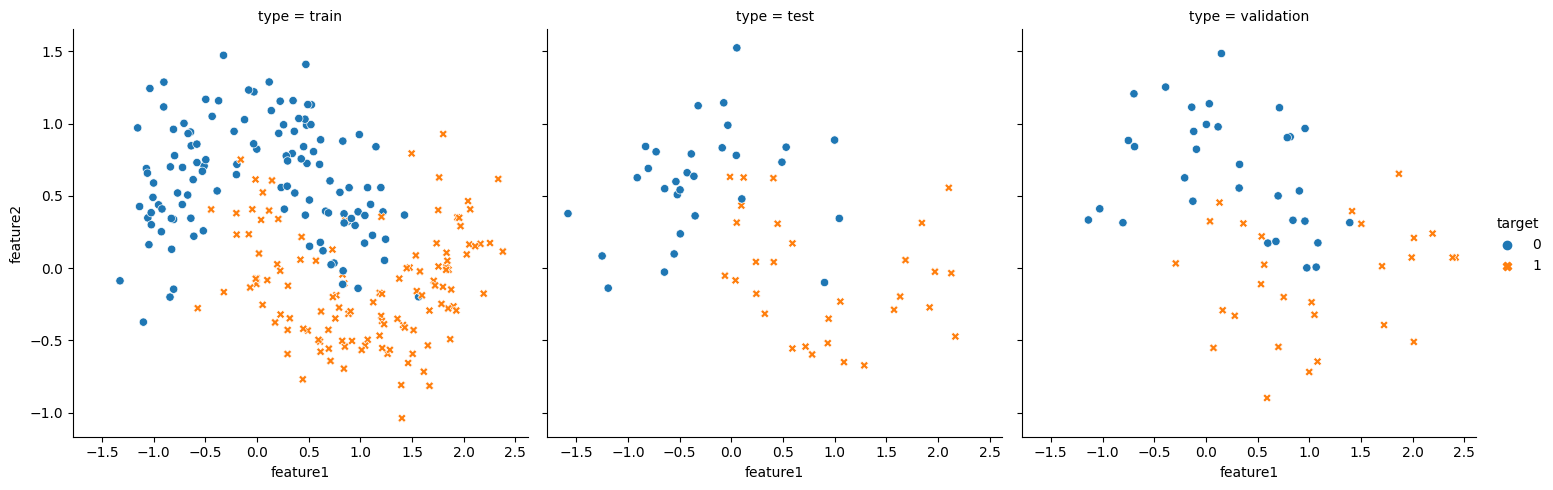

In [191]:
import seaborn as sns
import pandas as pd
# seaborn.regplot(
#     data=X_train, x=X_train[:, 0], y=X_train[:, 1], hue=y_train,marker='s')
# seaborn.regplot(
#     data=X_test, x=X_test[:, 0], y=X_test[:, 1], hue=y_test, marker='<')
# seaborn.regplot(
#     data=X_val, x=X_val[:, 0], y=X_val[:, 1], hue=y_val,  marker='>')
# seaborn.scatterplot(data=X_test)
# seaborn.scatterplot(data=X_val)
train_df = pd.DataFrame(
    {'feature1': X_train[:, 0], 'feature2': X_train[:, 1], 'target': y_train, 'type': 'train'})
test_df = pd.DataFrame(
    {'feature1': X_test[:, 0], 'feature2': X_test[:, 1], 'target': y_test, 'type': 'test'})
validation_df = pd.DataFrame(
    {'feature1': X_val[:, 0], 'feature2': X_val[:, 1], 'target': y_val, 'type': 'validation'})
df = pd.concat([train_df, test_df, validation_df])

sns.relplot(
    data=df, x="feature1", y="feature2",
    col="type", hue="target", style="target",
    kind="scatter"
)


<Axes: xlabel='feature1', ylabel='feature2'>

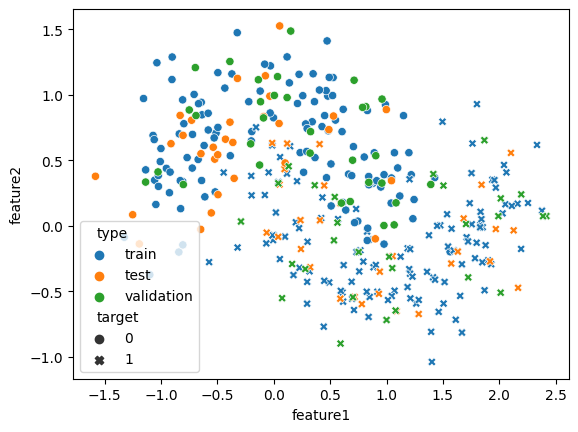

In [192]:
sns.scatterplot(data=df, x='feature1', y='feature2',
                hue='type', style='target')


## Ejercicio 2

- Defina una función que dado el grado del polinomio, devuelve un `Pipeline` consistente de un pre-procesado polinómico y un regresor logístico (usando `penalty='none'`). Opcionalmente puede introducir un `StandardScaler` como paso intermedio
- Itere sobre los grados polinóomicos de 1 a 10, fiteando un regresor polinómico sobre el conjunto de entrenamiento. Guarde en arrays su exactitud sobre los conjuntos de entrenamiento y validación.
- Plotee los arrays de exactitud sobre los conjuntos de entrenamiento y validación en función del grado polinómico.
- Encuentre el grado polinómico que maximiza la exactitud de validación.
- Entrene un regresor polinómico del grado óptimo encontrado sobre el dataset extendido de entrenamiento+validación. Este es su modelo final.
- Mida la exactitud del modelo final sobre el conjunto de evaluación.
- Opcional: Grafique la frontera de decisión.


In [193]:
# Tu turno...
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
accuracies_val = []
accuracies_train = []
MAX_DEGREE = 10
for d in range(1, MAX_DEGREE):
    print(f"Grado:{d}")
    pipazo = make_pipeline(
        PolynomialFeatures(degree=d),
        StandardScaler(),
        LogisticRegression(
            penalty=None,
            max_iter=9999999999999999999)
    )
    pipazo.fit(X_train, y_train)
    preds_val = pipazo.predict(X_val)
    preds_train = pipazo.predict(X_train)
    accuracies_val.append(accuracy_score(preds_val, y_val))
    accuracies_train.append(accuracy_score(preds_train, y_train))


Grado:1
Grado:2
Grado:3
Grado:4
Grado:5
Grado:6


/home/cris/Documents/introIA/guias-iia-lcd-unsam/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grado:7


/home/cris/Documents/introIA/guias-iia-lcd-unsam/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grado:8


/home/cris/Documents/introIA/guias-iia-lcd-unsam/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Grado:9


/home/cris/Documents/introIA/guias-iia-lcd-unsam/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


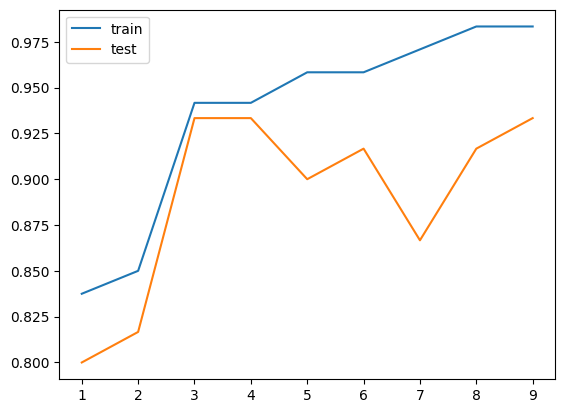

In [194]:
plt.plot(range(1, MAX_DEGREE), accuracies_train, label='train')
plt.plot(range(1, MAX_DEGREE), accuracies_val, label='test')
plt.legend()


In [195]:
# modelo final
final_degree = 3
final_pipeline = make_pipeline(
    PolynomialFeatures(degree=final_degree),
    StandardScaler(),
    LogisticRegression(
        penalty=None,
        max_iter=1000000000)
)
# Concatenating operation
# axis = 1 implies that it is being done column-wise
final_pipeline.fit(
    np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)))

predict_final_pipe = final_pipeline.predict(X_val)
accuracy_score(predict_final_pipe, y_val)


0.95

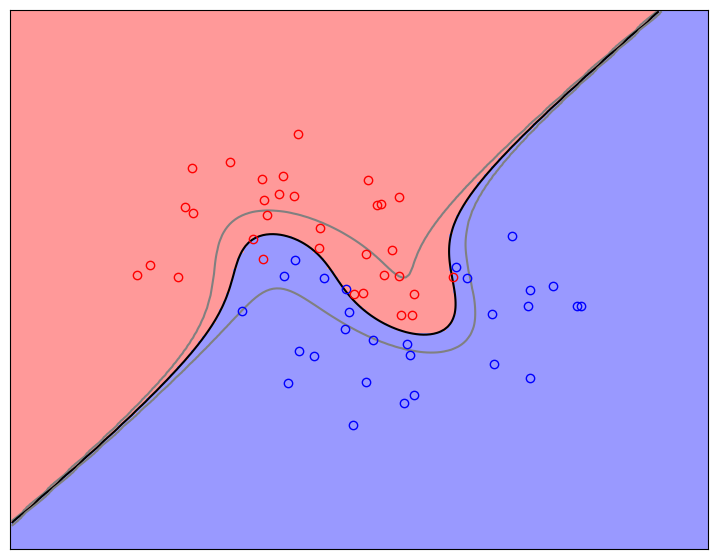

In [196]:
plot_regions(final_pipeline, X_val, y_val)


## Regularización


## Ejercicio 3

- Elija un tipo de regularización (L1 o L2)
- Modifique la función del ejercicio anterior para que acepte como parametros el argumento `C` e inicialice el regresor logístico con ese parámetro y el `penalty` correspondiente a la regularización escogida.
- Entrene y compare las fronteras de decisión de los siguientes regresores logísticos polinómicos (del grado óptimo obtenido en el ejericio 2):
  - sin regularizar (`penalty='none'` o bien `C=1e16`)
  - medianamente regularizado (`C~1`)
  - altamente regularizado (`C ≤ 0.001`)


In [197]:
# Tu turno...# modelo final
final_degree = 3
final_pipeline_reg = make_pipeline(
    PolynomialFeatures(degree=final_degree),
    StandardScaler(),
    LogisticRegression(
        max_iter=1000000000, penalty='l2'        # ,penalty=None
        , C=0.001
        # ,C=1
    )
)

final_pipeline_reg.fit(
    np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)))

predict_final_pipe = final_pipeline_reg.predict(X_val)
accuracy_score(predict_final_pipe, y_val)


0.8

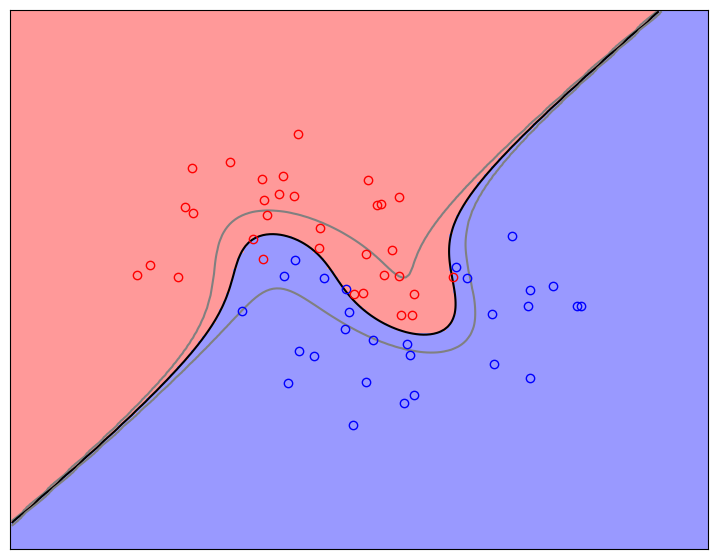

In [198]:
plot_regions(final_pipeline, X_val, y_val)


## Ejercicio 4

- Defina una grilla de hiperparámetros (para `C` y `degree`).
- Entrene (sobre el conjunto de entrenamiento) regresores logísticos polinómicos para cada combinación de hiperparámetros de la grilla, registrando sus exactitudes sobre el conjunto de validación.
- Encuentre la combinación de hiperparámetros óptima para este modelo y dataset
- Entrene el modelo óptimo sobre el conjunto extendido de entrenamiento + validación.
- Mida la exactitud de este modelo final sobre el conjunto de evaluación. Compare con la obtenida en el Ejercicio 2.
- Opcional: Grafique la frontera de decisión.

_Pista:_

- _Para hacerlo simple, considere dos bucles anidados._


In [199]:
# Defina una grilla de hiperparámetros (para C y degree).
# Entrene (sobre el conjunto de entrenamiento) regresores logísticos polinómicos para cada combinación de hiperparámetros de la grilla, registrando sus exactitudes sobre el conjunto de validación.
# Encuentre la combinación de hiperparámetros óptima para este modelo y dataset
C = [0.001, 1, 1e-16]
MAX_DEGREE_AYUDAME_LOCO = 10
accuracies_test_mad_help_me = []
for c in enumerate(C):
    accuracies_test_mad_help_me.append([c[1]])
    # print(d)
    for d in range(1, MAX_DEGREE_AYUDAME_LOCO):
        # accuracies_test_mad_help_me[c[0]].append(d)
        pipe_help_me = make_pipeline(
            PolynomialFeatures(degree=d),
            StandardScaler(),
            LogisticRegression(
                # penalty=None,
                C=c[1],
                max_iter=1000000000))
        pipe_help_me.fit(X_val, y_val)
        preds_val_uwu = pipe_help_me.predict(X_val)
        accuracies_test_mad_help_me[c[0]].append(
            accuracy_score(preds_val_uwu, y_val))
        # print(c)
print(accuracies_test_mad_help_me[0])
print(accuracies_test_mad_help_me[1])
print(accuracies_test_mad_help_me[2])


[0.001, 0.5333333333333333, 0.5333333333333333, 0.5833333333333334, 0.6, 0.65, 0.65, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
[1, 0.8, 0.8333333333333334, 0.8666666666666667, 0.85, 0.8666666666666667, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333]
[1e-16, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7833333333333333, 0.7833333333333333, 0.8, 0.8333333333333334]


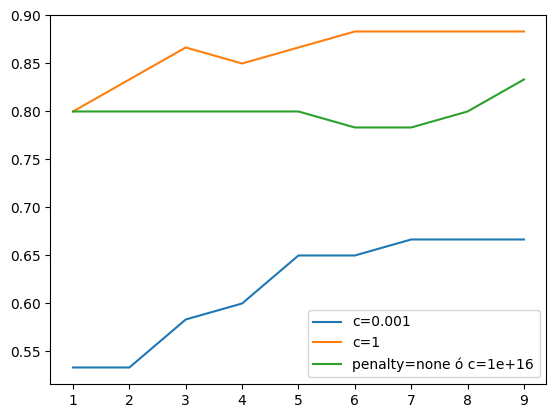

In [200]:
plt.plot(range(1, MAX_DEGREE_AYUDAME_LOCO),
         accuracies_test_mad_help_me[0][1:], label='c=0.001')
plt.plot(range(1, MAX_DEGREE_AYUDAME_LOCO),
         accuracies_test_mad_help_me[1][1:], label='c=1')
plt.plot(range(1, MAX_DEGREE_AYUDAME_LOCO),
         accuracies_test_mad_help_me[2][1:], label='penalty=none ó c=1e+16')
# plt.plot(range(1,MAX_DEGREE),accuracies_test_mad_help_me[1],label='test')
plt.legend()


In [201]:
# Del grafico de arriba obtengo que la mejor combinacion de hiperparámetros seria:
#  * Grado del polinomio = 3
#  * c = 1


In [202]:
# Entrene el modelo óptimo sobre el conjunto extendido de entrenamiento + validación.
# Mida la exactitud de este modelo final sobre el conjunto de evaluación. Compare con la obtenida en el Ejercicio 2.
# Opcional: Grafique la frontera de decisión.
mejor_grado = 3
mejor_c = 1
el_mejor_mas_grande_pipe = make_pipeline(
    PolynomialFeatures(degree=mejor_grado),
    StandardScaler(),
    LogisticRegression(
        # penalty=None,
        C=mejor_c,
        max_iter=1000000000))

el_mejor_mas_grande_pipe.fit(
    np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)))

predict_mejor_pipe = el_mejor_mas_grande_pipe.predict(X_val)
accuracy_score(predict_mejor_pipe, y_val)


0.8333333333333334

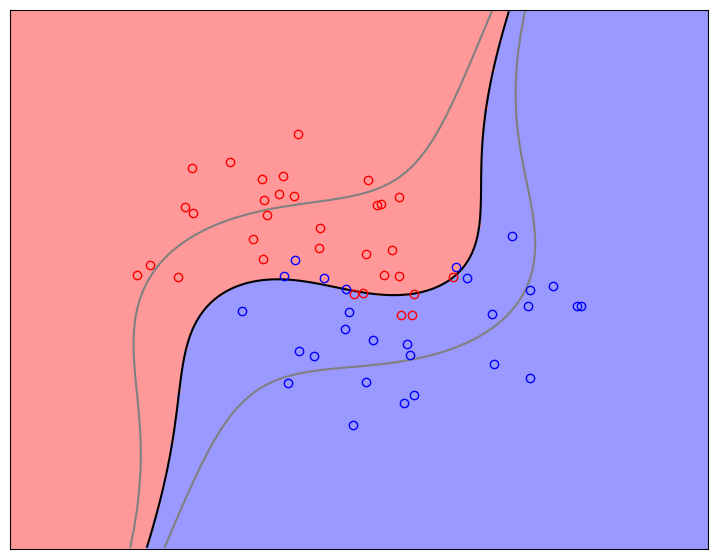

In [203]:
plot_regions(el_mejor_mas_grande_pipe, X_val, y_val)


## Ejercicio 5: Regresión


En la [guía 2](https://github.com/LCD-UNSAM/iaa2023c1/blob/main/guias/IAA_Guia_2_RegresionLineal_Ejercitacion.ipynb) se le pidió que realice un ajuste lineal para un caso de regresión. Repita el ejercicio, pero ahora en vez de utilizar la clase `sklearn.linear_model.LinearRegression`, utilice alguna(s) de las siguientes:

- `sklearn.linear_model.Ridge`: Regresión lineal que implementa la regularización L2
- `sklearn.linear_model.Lasso`: Regresión lineal que implementa la regularización L1
- `sklearn.linear_model.ElasticNet`: Regresión lineal que implementa la regularización ElasticNet (una combinación lineal de L1 y L2)


In [204]:

# Tu turno...

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
# el_classifier = make_pipeline(
#     # ElasticNet(),
#     # Lasso(),
#     Ridge(),
# )


def classifier_pipe(model):
    return make_pipeline(
        model
        # ElasticNet(),
        # Lasso(),
        # Ridge(),
    )


lasso = classifier_pipe(Lasso()).fit(X_train, y_train)
ridge = classifier_pipe(Ridge()).fit(X_train, y_train)
elastic = classifier_pipe(ElasticNet()).fit(X_train, y_train)
# .fit(X_train, y_train)
# print(lasso)
y_ll_pred_test = lasso.predict(X_test)
y_ll_pred_train = lasso.predict(X_train)


def get_model_scores(model, modelName, X_train, y_train, X_test, y_test, X_val, y_val):

    print(f'mean squared error on train set for {modelName}')
    print(np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print(f'r2 score on train set for {modelName}')
    print(r2_score(y_train, model.predict(X_train)))
    print(f'mean squared error on test set for {modelName}')
    print(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print(f'r2 score on test set for {modelName}')
    print(r2_score(y_test, model.predict(X_test)))
    print(f'mean squared error on validation set for {modelName}')
    print(np.sqrt(mean_squared_error(y_val, model.predict(X_val))))
    print(f'r2 score on validation set for {modelName}')
    print(r2_score(y_val, model.predict(X_val)))


get_model_scores(lasso, 'lasso', X_train, y_train,
                 X_test, y_test, X_val, y_val)
get_model_scores(ridge, 'ridge', X_train, y_train,
                 X_test, y_test, X_val, y_val)
get_model_scores(elastic, 'elastic', X_train, y_train,
                 X_test, y_test, X_val, y_val)


mean squared error on train set for lasso
0.49993055073235465
r2 score on train set for lasso
0.0
mean squared error on test set for lasso
0.5000694396225833
r2 score on test set for lasso
-0.0002777777777778212
mean squared error on validation set for lasso
0.5006246098625197
r2 score on validation set for lasso
-0.006975446428571175
mean squared error on train set for ridge
0.3316536176488138
r2 score on train set for ridge
0.5599012619523598
mean squared error on test set for ridge
0.3275534706101716
r2 score on test set for ridge
0.5708348955649258
mean squared error on validation set for ridge
0.33818917975923546
r2 score on validation set for ridge
0.5404699590374911
mean squared error on train set for elastic
0.49993055073235465
r2 score on train set for elastic
0.0
mean squared error on test set for elastic
0.5000694396225833
r2 score on test set for elastic
-0.0002777777777778212
mean squared error on validation set for elastic
0.5006246098625197
r2 score on validation set for

### Formulario de asistencia

Por favor, no olviden completar el siguiente formulario antes del miércoles 26/04 a la 23:59.

(link TBD)
